In [88]:
import numpy as np
import time
import os
import glob
import IPython.display
import matplotlib.pyplot as plt
np.random.seed(1337)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from PIL import Image
from keras.layers.normalization import BatchNormalization

In [95]:
# Define the parameters for training
batch_size = 128
nb_classes = 2
nb_epoch = 40

# input image dimensions
img_rows, img_cols = 11, 11

# Volume of the training set
sample_number = 100000

# number of conv filters to use
nb_filters = 112

# CNN kernel size
kernel_size = (3,3)

1. Training set contains 50,000 pairs of positive-matching samples and 50,000 pairs of negative-matching samples. The volume of our training set is far smaller than the paper (i.e., they use ~260,000,000 samples).
2. We load all the training set into a 3D matrix.
3. Loading 50,000 pairs of images takes approximately 600 s.

In [85]:
# load the patches
X1_train = np.zeros((sample_number, img_rows, img_cols))
X2_train = np.zeros((sample_number, img_rows, img_cols))
y_train = np.zeros((sample_number,))

tic = time.time()
# Load the training set.
for i in xrange(50000):
    X1_train[2*i, :,:] = np.array(Image.open("/home/qw2208/research/patches/{}L.png".format(i)))
    X1_train[(2*i+1),:,:] = np.array(Image.open("/home/qw2208/research/patches/{}L.png".format(i)))
    X2_train[2*i:,:] = np.array(Image.open("/home/qw2208/research/patches/{}RNegative.png".format(i)))
    X2_train[(2*i+1),:,:] = np.array(Image.open("/home/qw2208/research/patches/{}RPositive.png".format(i)))
    y_train[2*i] = 0
    y_train[2*i+1] = 1
    
toc = time.time()
print "Time for loading the training set: ", toc-tic

Time for loading the training set:  596.407830954


1. Here some additional preprocess methods like rotation etc. could be added.
2. Normalization missed.

In [86]:
# Resize the dataset (Trivial)
if K.image_dim_ordering() == 'th':
    X1_train = X1_train.reshape(X1_train.shape[0], 1, img_rows, img_cols)
    X2_train = X2_train.reshape(X2_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1,img_rows, img_cols)
else:
    X1_train = X1_train.reshape(X1_train.shape[0], img_rows, img_cols, 1)
    X2_train = X2_train.reshape(X2_train.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols,1)

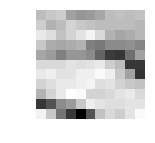

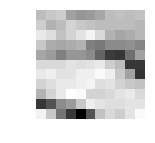

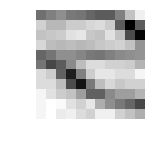

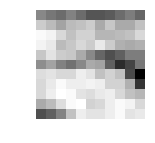

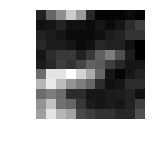

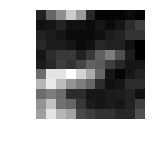

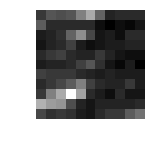

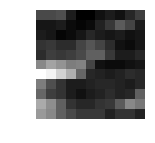

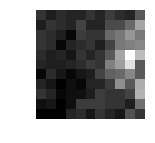

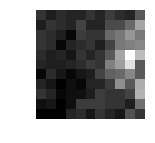

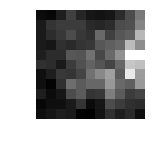

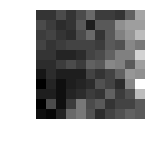

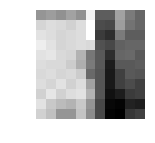

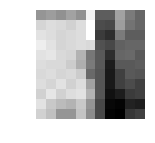

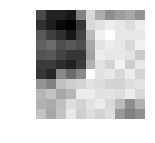

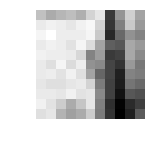

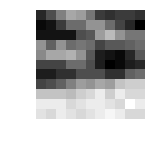

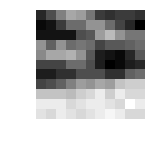

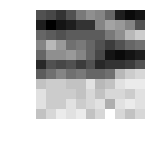

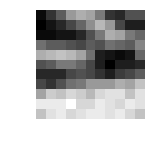

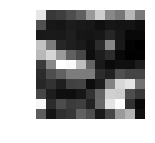

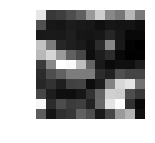

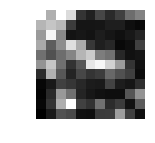

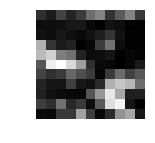

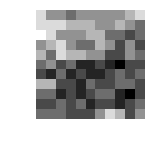

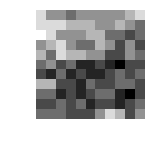

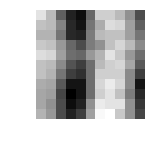

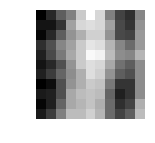

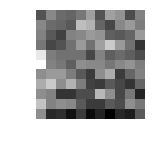

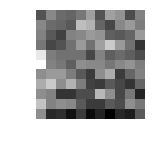

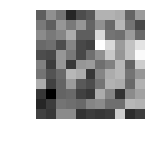

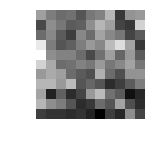

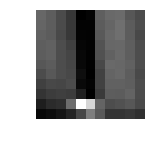

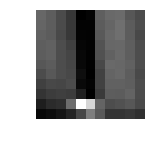

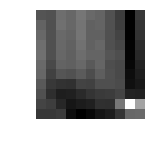

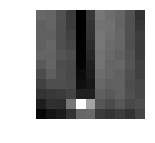

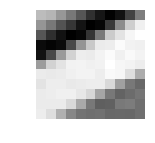

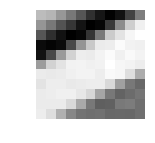

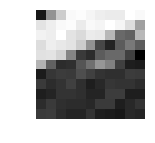

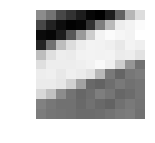

In [75]:
# Briefly check some patches.
# Positive-matching patches are expected to be of similar features.
# We store two left patches in X1_train.
# One for matching the positve right patch. 
# The other for matching negative right patch.

for i in xrange(20,30):
    # Left patch - 1
    plt.imshow(X1_train[2*i][0], cmap=plt.get_cmap('gray'))
    plt.gca().axis('off')
    plt.gcf().set_size_inches((2, 2))
    plt.show()

    # Left patch - 2
    plt.imshow(X1_train[2*i+1][0], cmap=plt.get_cmap('gray'))
    plt.gca().axis('off')
    plt.gcf().set_size_inches((2, 2))
    plt.show()

    # Negative-matching patch
    plt.imshow(X2_train[2*i][0], cmap=plt.get_cmap('gray'))
    plt.gca().axis('off')
    plt.gcf().set_size_inches((2, 2))
    plt.show()

    # Positive-matching patch
    plt.imshow(X2_train[2*i+1][0], cmap=plt.get_cmap('gray'))
    plt.gca().axis('off')
    plt.gcf().set_size_inches((2, 2))
    plt.show()

X1_train = X1_train.astype('float32')
X2_train = X2_train.astype('float32')

This neural network is working finely and ends up with a training accuracy of more than 90%. Some units are missing:
1. Data augment: Rotation, transformation and etc.
2. Volume of the training set. 
3. I haven't split the training set into training set and validation set. And the evaluation of the network is based on the whole training set, which is not permitted.

In [96]:
# https://keras-cn.readthedocs.io/en/latest/getting_started/sequential_model/#merge
left_branch = Sequential()
left_branch.add(BatchNormalization(input_shape=input_shape,axis=1))
left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', input_shape=input_shape))
left_branch.add(Activation('relu'))
left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
left_branch.add(Activation('relu'))
left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
left_branch.add(Activation('relu'))
left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
left_branch.add(Activation('relu'))

right_branch = Sequential()
right_branch.add(BatchNormalization(input_shape=input_shape,axis=1))
right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', input_shape=input_shape))
right_branch.add(Activation('relu'))
right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
right_branch.add(Activation('relu'))
right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
right_branch.add(Activation('relu'))
right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
right_branch.add(Activation('relu')) 

merged = Merge([left_branch, right_branch], mode='concat')
fc = Sequential()
fc.add(merged)
fc.add(Flatten())
fc.add(Dense(384, activation='relu'))
fc.add(Dense(384, activation='relu'))
fc.add(Dense(384, activation='relu'))

fc.add(Dense(1, activation='sigmoid'))

fc.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
fc.fit([X1_train,X2_train], y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=0, shuffle=True, callbacks=[TQDMNotebookCallback()])

# Evaluate the result based on the training set
score = fc.evaluate([X1_train,X2_train], y_train, verbose=0)
print('Test score: ', score[0])
print('Test accuracy: ', score[1])


('Test score: ', 0.16412427104979754)
('Test accuracy: ', 0.94337000000000004)


We need to store the trained network. This is not finished.

In [94]:
fc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_11 (BatchNorma(None, 1, 11, 11)     2                                            
____________________________________________________________________________________________________
convolution2d_97 (Convolution2D) (None, 112, 11, 11)   1120                                         
____________________________________________________________________________________________________
activation_97 (Activation)       (None, 112, 11, 11)   0                                            
____________________________________________________________________________________________________
convolution2d_98 (Convolution2D) (None, 112, 11, 11)   113008                                       
___________________________________________________________________________________________